In [1]:
import pandas as pd
import numpy as np
import jax as jax
jax.config.update("jax_enable_x64", True)
import Utilityfunctions as utils
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression

In [8]:
mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_30and5_Full.csv"
annot_handle = "../data/paad/G12_PAADPANET_PM_z10_sampleSelection.csv"

annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

# Remove datapoints, that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]
dat.columns

Index(['patientID', 'P.Mut.KRAS', 'M.Mut.KRAS', 'P.Mut.TP53', 'M.Mut.TP53',
       'P.gAEP033', 'M.gAEP033', 'P.chr18.del.single.1',
       'M.chr18.del.single.1', 'P.chrX.del.single.1', 'M.chrX.del.single.1',
       'P.Mut.SMAD4', 'M.Mut.SMAD4', 'P.chr20.amp.single.1',
       'M.chr20.amp.single.1', 'P.chr17.del.single.1', 'M.chr17.del.single.1',
       'P.Mut.CDKN2A', 'M.Mut.CDKN2A', 'P.Mut.ARID1A', 'M.Mut.ARID1A',
       'P.Mut.RNF43', 'M.Mut.RNF43', 'P.Mut.MEN1', 'M.Mut.MEN1',
       'P.Mut.TGFBR2', 'M.Mut.TGFBR2', 'P.Mut.KDM6A', 'M.Mut.KDM6A',
       'P.Mut.KMT2D', 'M.Mut.KMT2D', 'P.Mut.GNAS', 'M.Mut.GNAS', 'P.Mut.DAXX',
       'M.Mut.DAXX', 'P.Mut.KMT2C', 'M.Mut.KMT2C', 'P.Mut.ATM', 'M.Mut.ATM',
       'P.Mut.RBM10', 'M.Mut.RBM10', 'P.Mut.BRCA2', 'M.Mut.BRCA2',
       'P.Mut.SETD2', 'M.Mut.SETD2', 'P.Mut.ATRX', 'M.Mut.ATRX',
       'P.Mut.PIK3CA', 'M.Mut.PIK3CA', 'P.Mut.RB1', 'M.Mut.RB1',
       'P.Mut.TGFBR1', 'M.Mut.TGFBR1', 'P.Mut.SMARCA4', 'M.Mut.SMARCA4',
       'P.Mut.SMAD3

In [9]:
start = 'P.Mut.KRAS'
stop = 'M.Mut.PTPRT'
mult = dat.set_index(["paired", "metaStatus"])
cleaned = mult.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
cleaned = cleaned.sort_index()
cleaned.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
cleaned.loc[(0, "absent"), "Seeding"] = 0
cleaned.loc[(1, "isPaired"), "Seeding"] = 1
dat_prim_nomet, dat_met_only, dat_prim_met, dat_coupled = utils.split_data(cleaned)
print(dat_prim_nomet.shape[0], dat_prim_met.shape[0], dat_coupled.shape[0], dat_met_only.shape[0])

118 973 74 1022


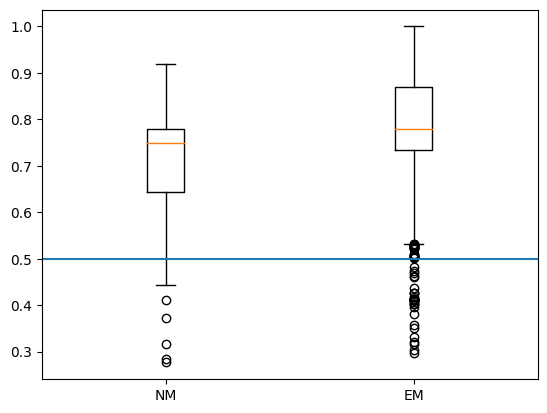

In [10]:
params = pd.read_csv("../results/luad/paired_20_8_0011.csv", index_col=0)
th_learned = params.iloc[:,:-1].to_numpy()
lam1 = np.exp(params.iloc[0,-1])
events = params.columns[:-1]
n = th_learned.shape[0]
prim_probs = np.zeros(dat_prim_nomet.shape[0])
em_probs = np.zeros(dat_prim_met.shape[0])
for i in range(dat_prim_nomet.shape[0]):
    prim_probs[i] = utils.p_unobs_seeding(jnp.array(th_learned), lam1, dat_prim_nomet.at[i,:].get())

for i in range(dat_prim_met.shape[0]):
    em_probs[i] = utils.p_unobs_seeding(jnp.array(th_learned), lam1, dat_prim_met.at[i,:].get())

mhn_probs = np.concatenate((prim_probs, em_probs))
plots = {"NM": prim_probs, "EM": em_probs}
fig, ax = plt.subplots()
ax.boxplot(plots.values())
ax.set_xticklabels(plots.keys())
ax.axhline(0.5)
plt.show()

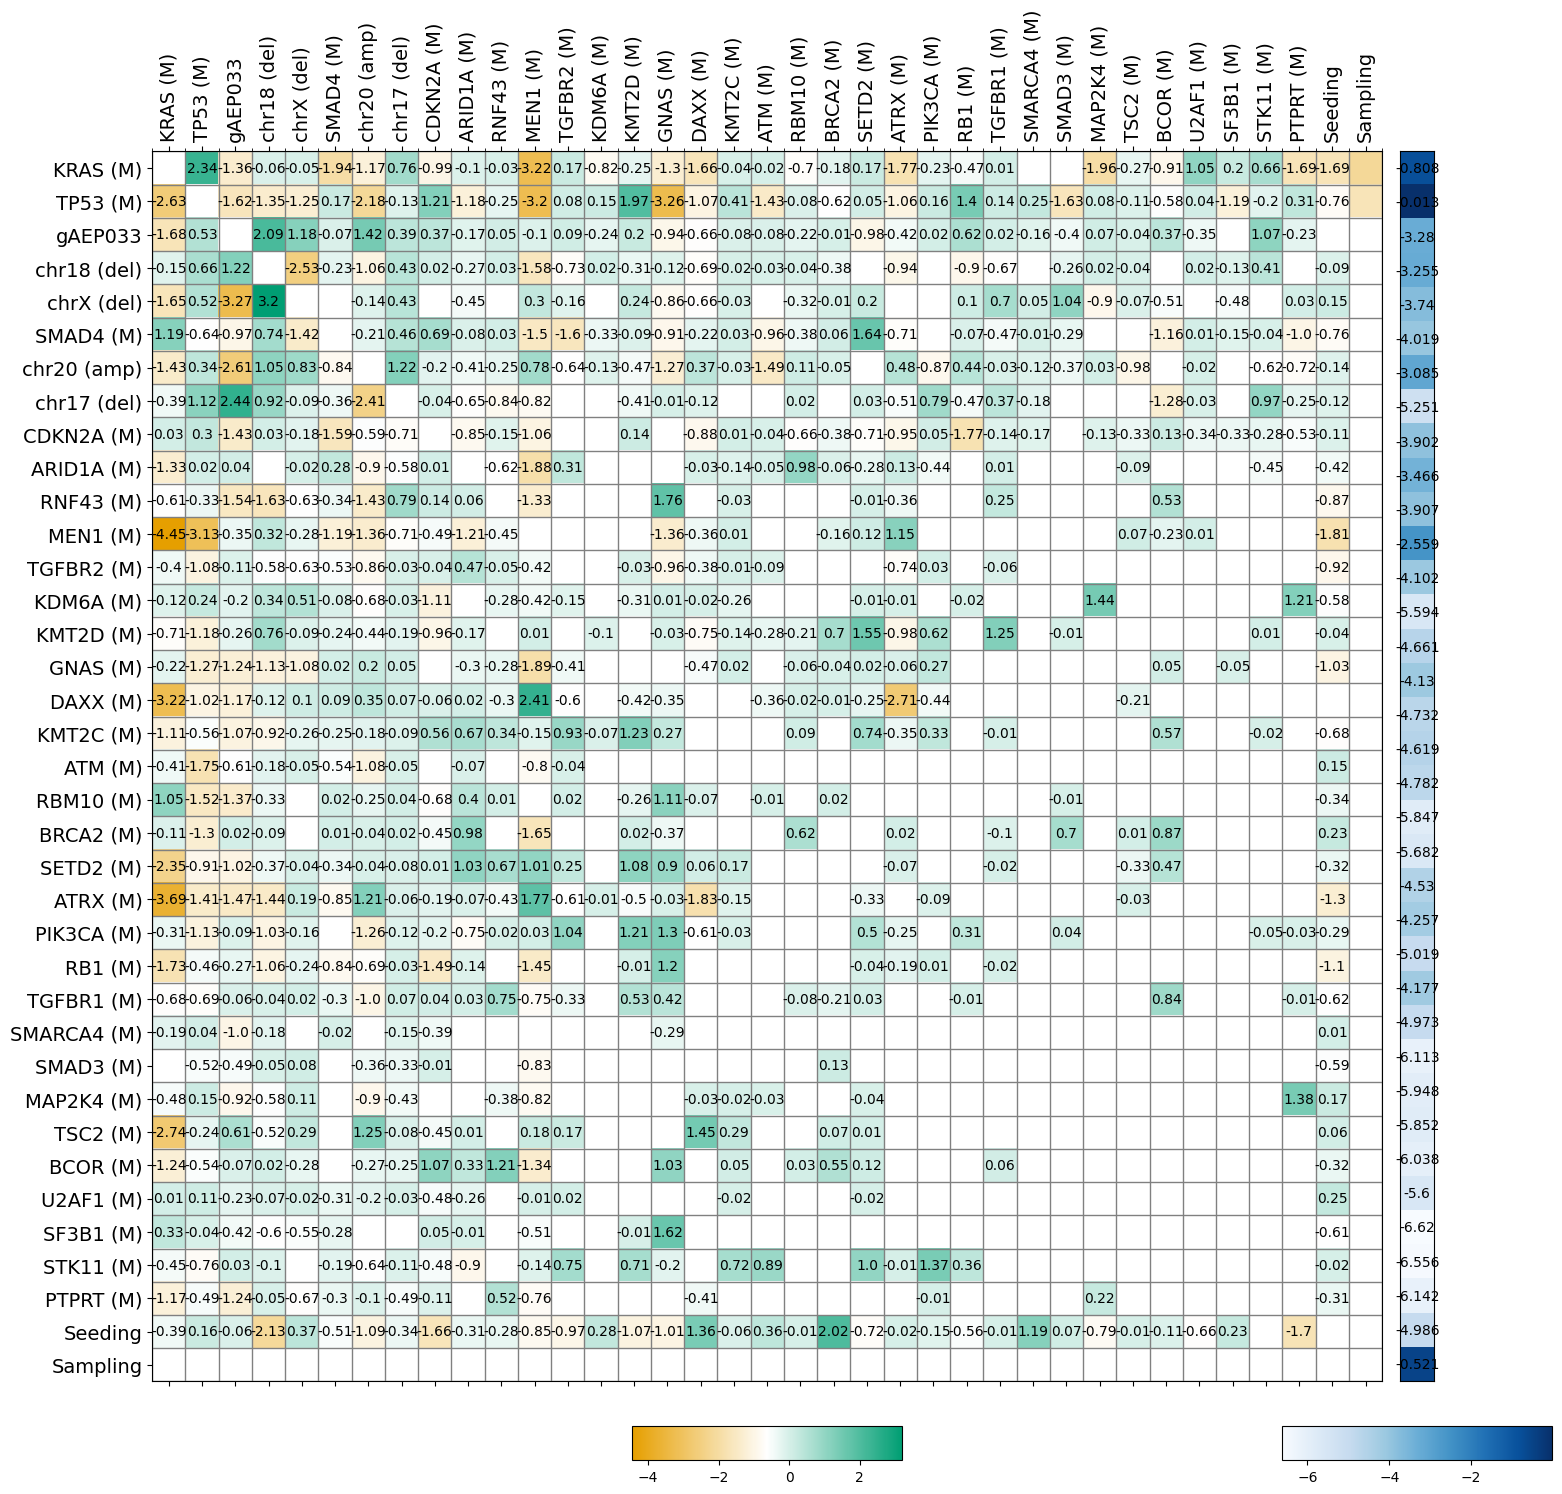

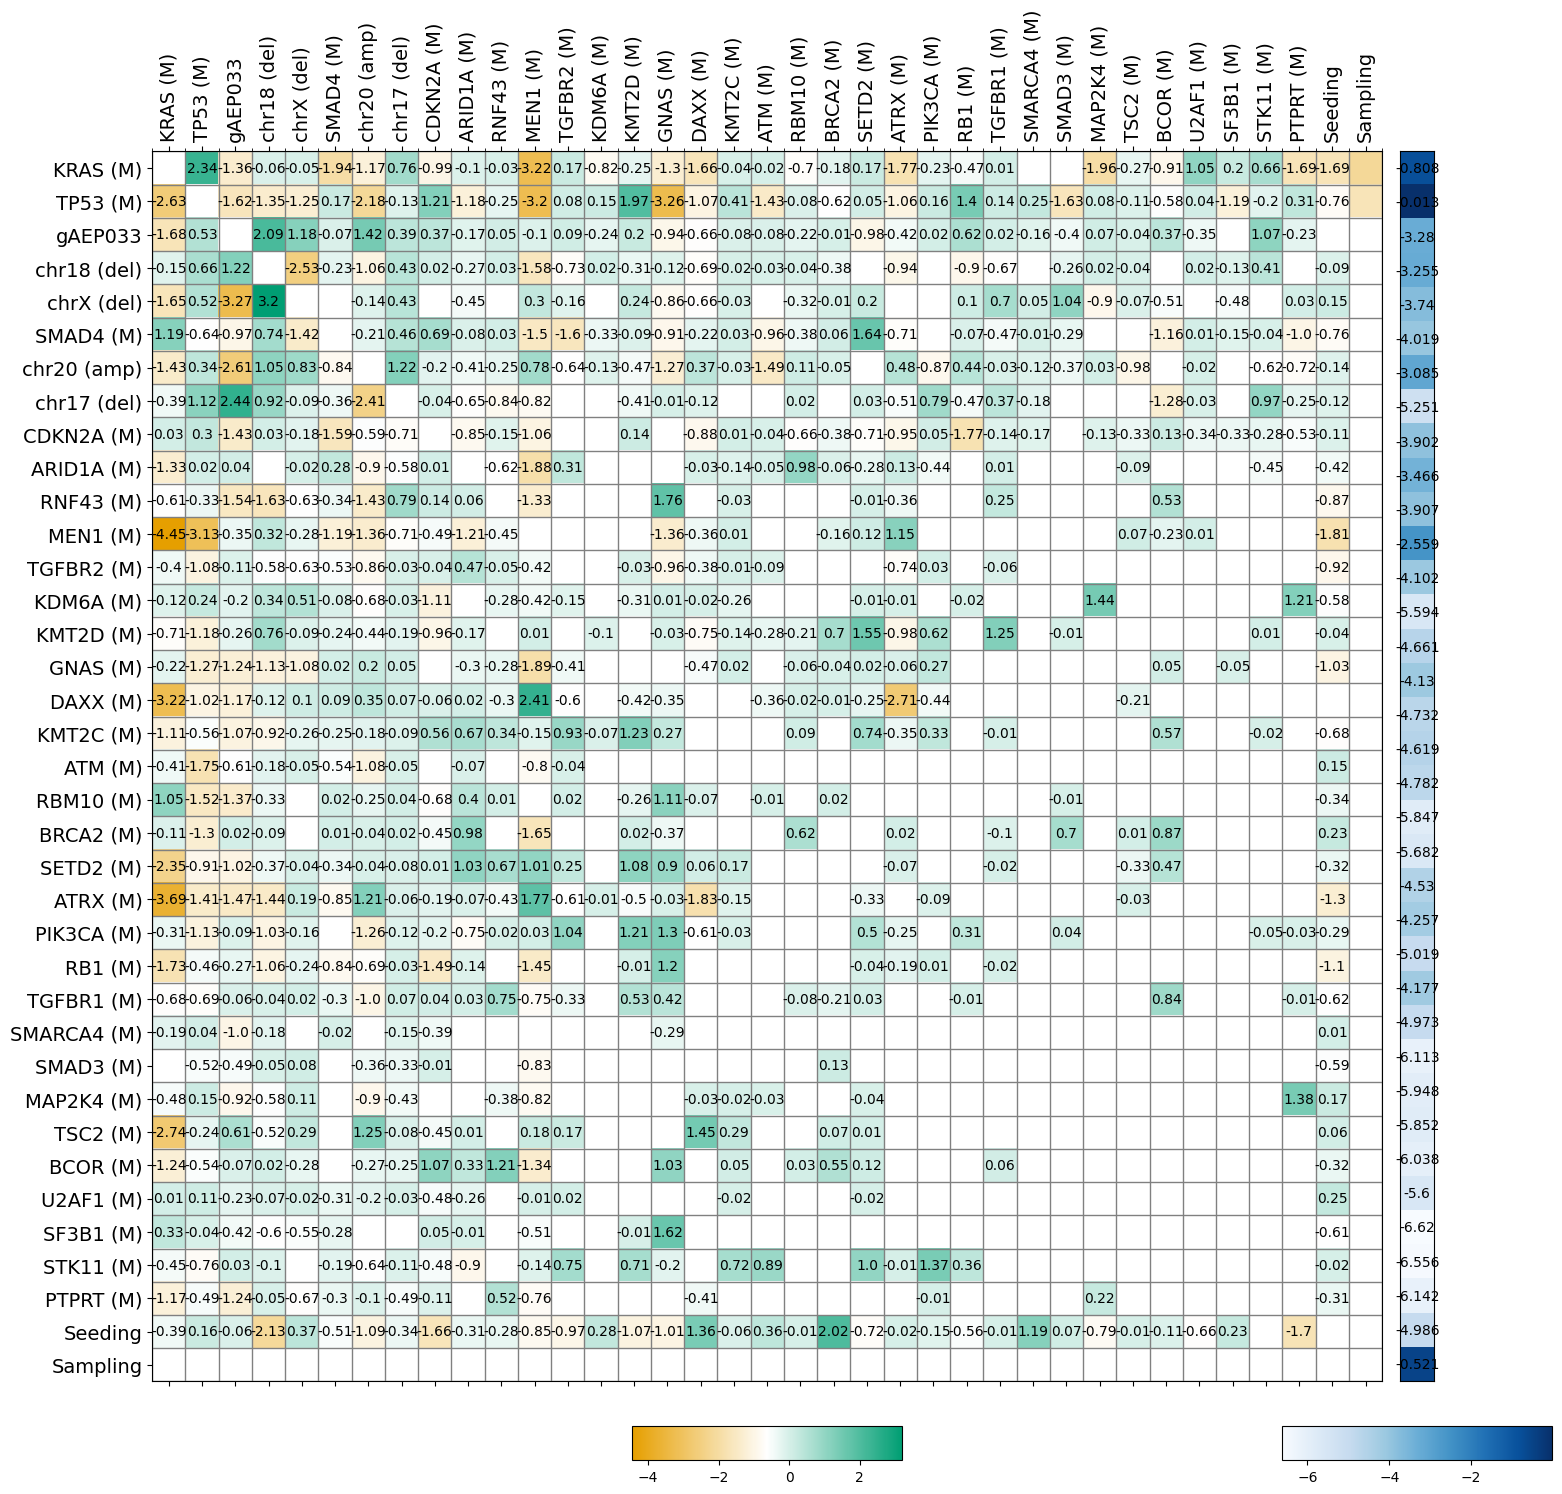

In [5]:
utils.plot_theta(params, 0.01)

0.5990907032243455 0.6573588586757713


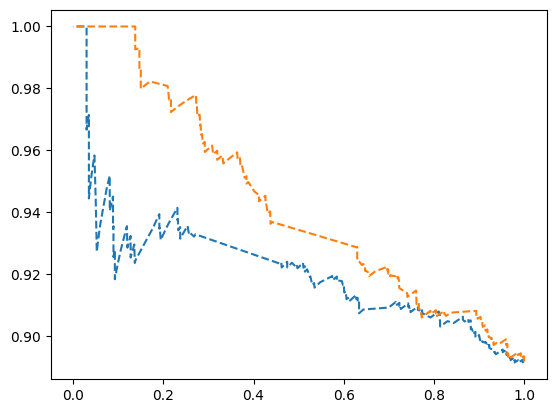

In [11]:
data_train = np.vstack((dat_prim_nomet.at[:,:-1:2].get(), dat_coupled.at[:,:-1:2].get()))
labels_train = np.concatenate((dat_prim_nomet.at[:, -1].get(), dat_coupled.at[:, -1].get()))

data_test = np.vstack((dat_prim_nomet.at[:,:-1:2].get(), dat_prim_met.at[:,:-1:2].get()))
labels_test = np.concatenate((dat_prim_nomet.at[:, -1].get(), dat_prim_met.at[:, -1].get()))
logReg = LogisticRegression(C=1, max_iter=1000)
logReg.fit(data_train, labels_train)
reg_probs = logReg.predict_proba(data_test)
mhn_probs = np.concatenate((prim_probs, em_probs))
mhn_auc = roc_auc_score(labels_test, mhn_probs)
reg_auc = roc_auc_score(labels_test, reg_probs[:,1])
print(reg_auc, mhn_auc)
fpr, tpr, _ = roc_curve(labels_test, mhn_probs)
reg_fpr, reg_tpr, _ = roc_curve(labels_test, reg_probs[:, 1])
lr_precision, lr_recall, _ = precision_recall_curve(labels_test, reg_probs[:,1])
mhn_precision, mhn_recall, _ = precision_recall_curve(labels_test, mhn_probs)
plt.plot(lr_recall, lr_precision, linestyle="--")
plt.plot(mhn_recall, mhn_precision, linestyle="--")